The data set contains data from Men's fashion stores in Netherland for the year 1990.  
There are 400 records and 13 columns:

- **tsales**: annual sales in Dutch guilders

- **sales**: sales per square meter

- **margin**: gross-profit-margin

- **nown**: number of owners (managers)

- **nfull**: number of full-timers

- **npart**: number of part-timers

- **naux**: number of helpers (temporary workers)

- **hoursw**: total number of hours worked

- **hourspw**: number of hours worked per worker

- **inv1**: investment in shop-premises

- **inv2**: investment in automation.

- **ssize**: sales floorspace of the store (in m$^2$).

- **start**: year start of business

#Exploratory Data Analysis

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import feature_selection as fs
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from pandas.tools.plotting import scatter_matrix

%matplotlib inline

In [125]:

# read csv
df = pd.read_csv('Clothing.csv')

In [126]:
df.describe()

,Unnamed: 0,tsales,sales,margin,nown,nfull,npart,naux,hoursw,hourspw,inv1,inv2,ssize,start
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,200.500000,833584.212500,6334.751278,38.774230,1.283796,2.069384,1.565539,1.389747,121.137500,18.955044,58257.25525,27829.217000,151.050000,42.808462
std,115.614301,583463.838406,3739.343624,5.218184,0.639773,1.015598,0.705999,0.394514,64.435343,7.343363,107558.77087,41501.943418,112.498254,13.296070
min,1.000000,50000.000000,300.000000,16.000000,1.000000,1.000000,1.000000,1.000000,32.000000,5.707966,1000.00000,350.000000,16.000000,16.000000
25%,100.750000,495340.000000,3904.200000,37.000000,1.000000,1.923100,1.283300,1.333300,80.000000,13.541198,20000.00000,10000.000000,80.000000,37.000000
50%,200.500000,694227.000000,5278.935000,39.000000,1.000000,1.955600,1.283300,1.367300,104.000000,17.744585,22207.04000,22859.850000,120.000000,40.000000
75%,300.250000,976817.000000,7739.899250,41.000000,1.295225,2.066400,2.000000,1.367300,145.250000,24.302982,62269.23000,22859.850000,190.000000,42.000000
max,400.000000,5000000.000000,27000.000000,66.000000,10.000000,8.000000,9.000000,4.000000,582.000000,43.326020,1500000.00000,400000.000000,1214.000000,90.000000


In the retail industry, sales per square meter (or square foot) has been the standard for comparing performance.
For example:  
 - Around the globe, Apple computer got the highest sales per sq meter. The IFC Apple store has the highest sales per square meter.
 
 
We are trying to figure out the key features that drive retail shop performance.


**Notes**:  
High standard deviation for tsales and sales, but no real effect on margin (low standard deviation) ==> shops with high tsales might have more COGS but might also re-invest money in resources (nfull, part and naux) and premises (inv1, inv2) 

Hight standard deviation for inv1 (investment in shop-premises), inv2 (investment in automation) and ssize

**For your reference**:  

margin = (tsales - 'Cost of Goods Sold')/ tsales thus COGS = tsales - (margin * tsales)]

sales  = tsales / ssize

In [127]:
# check features summary info and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 14 columns):
Unnamed: 0    400 non-null int64
tsales        400 non-null int64
sales         400 non-null float64
margin        400 non-null float64
nown          400 non-null float64
nfull         400 non-null float64
npart         400 non-null float64
naux          400 non-null float64
hoursw        400 non-null int64
hourspw       400 non-null float64
inv1          400 non-null float64
inv2          400 non-null float64
ssize         400 non-null int64
start         400 non-null float64
dtypes: float64(10), int64(4)
memory usage: 46.9 KB


--> all are numeric data which is good!

In [128]:
# check if there is any missing data, if yes, print out 
for col in df.columns:
    for row in range(len(df.index)):
        if pd.isnull(df[col][row]):
            print 'missing value: col = ' + col + ' row = ' + str(row)
            

--> no missing value in dataset which is good!

array([[<matplotlib.axes.AxesSubplot object at 0x7f5d2b937b10>,
        <matplotlib.axes.AxesSubplot object at 0x7f5d21b251d0>]], dtype=object)

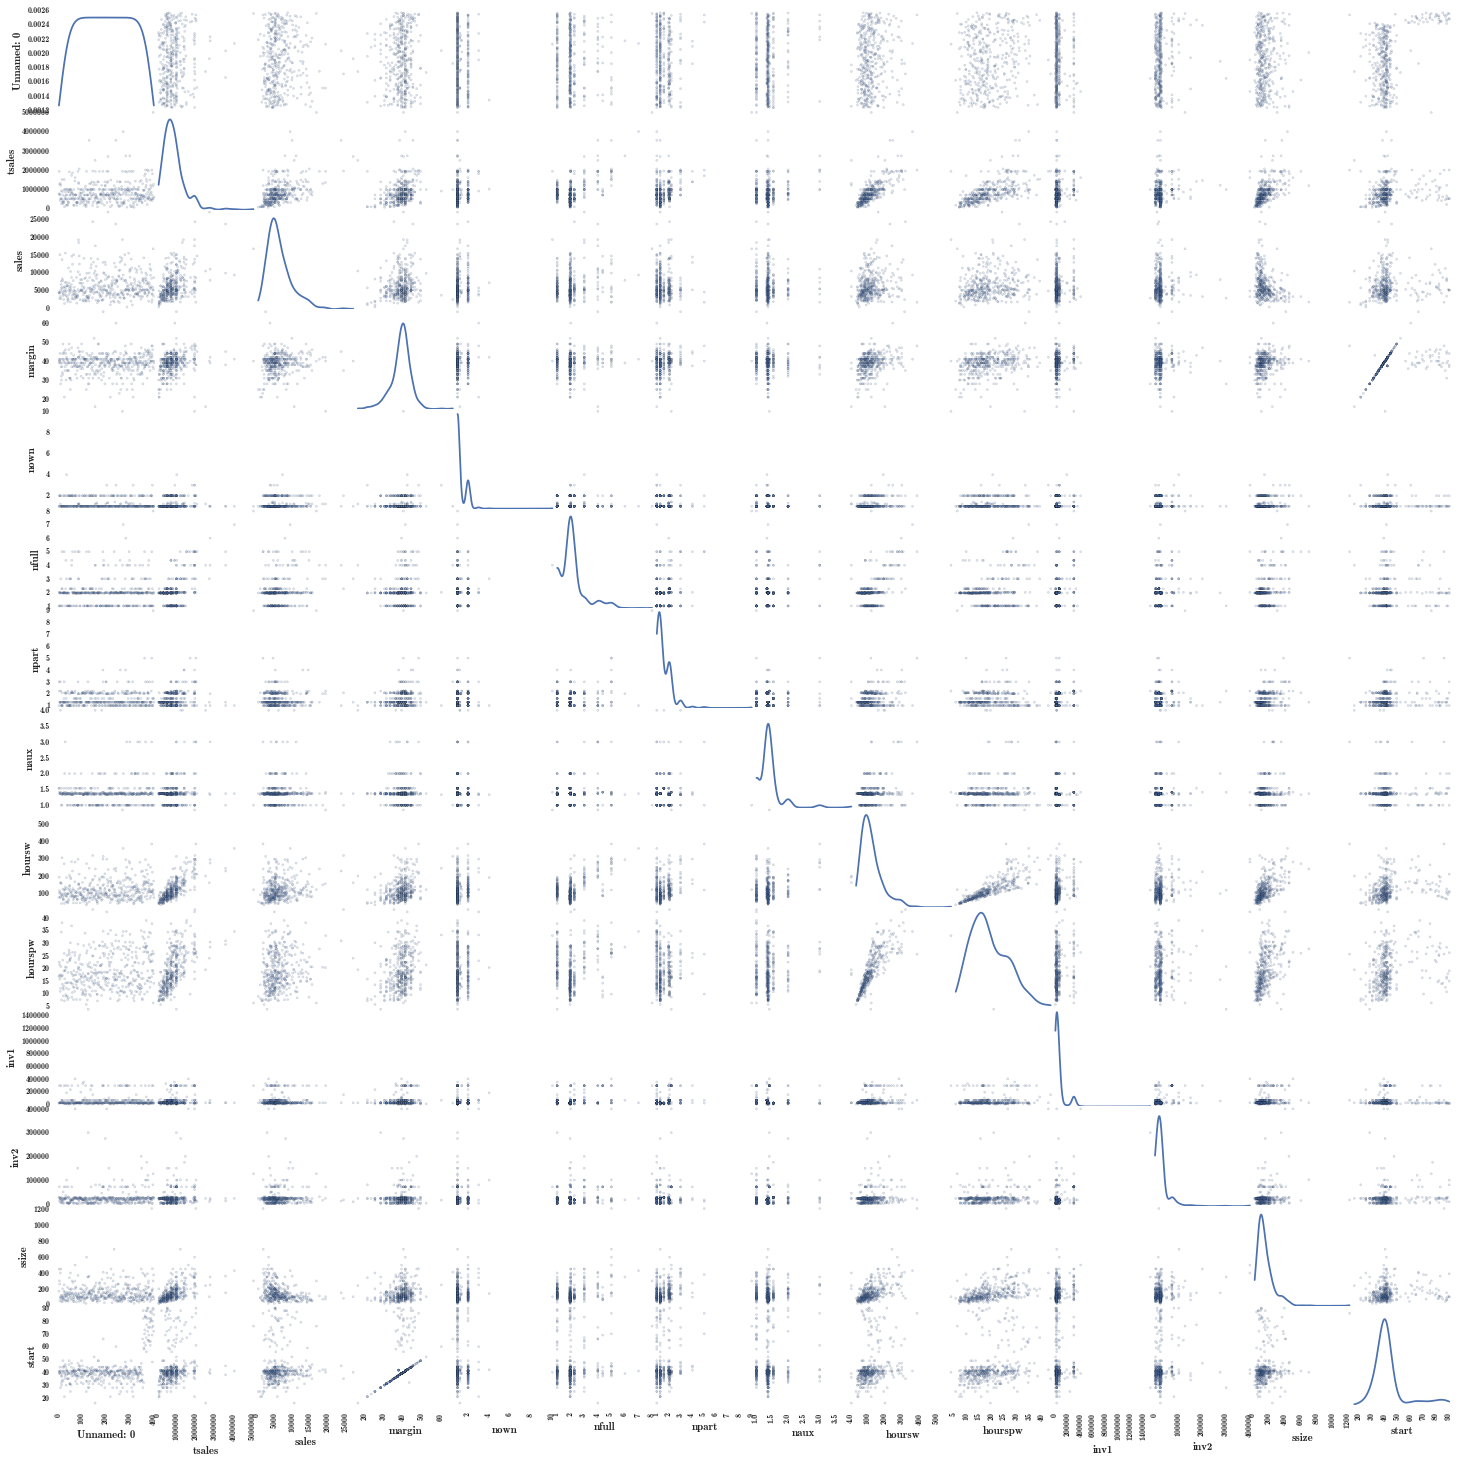

In [129]:
scatter_matrix(df, alpha=0.2, figsize=(25, 25), diagonal='kde')

 - there might be a link between sales and size, hoursw, hourspw
 - logical link between sales and tsales
 - link between hourspw and ssize
 - tight and logical link between hoursw and hourspw

array([[<matplotlib.axes.AxesSubplot object at 0x7f5d20921e10>,
        <matplotlib.axes.AxesSubplot object at 0x7f5d1f3d33d0>]], dtype=object)

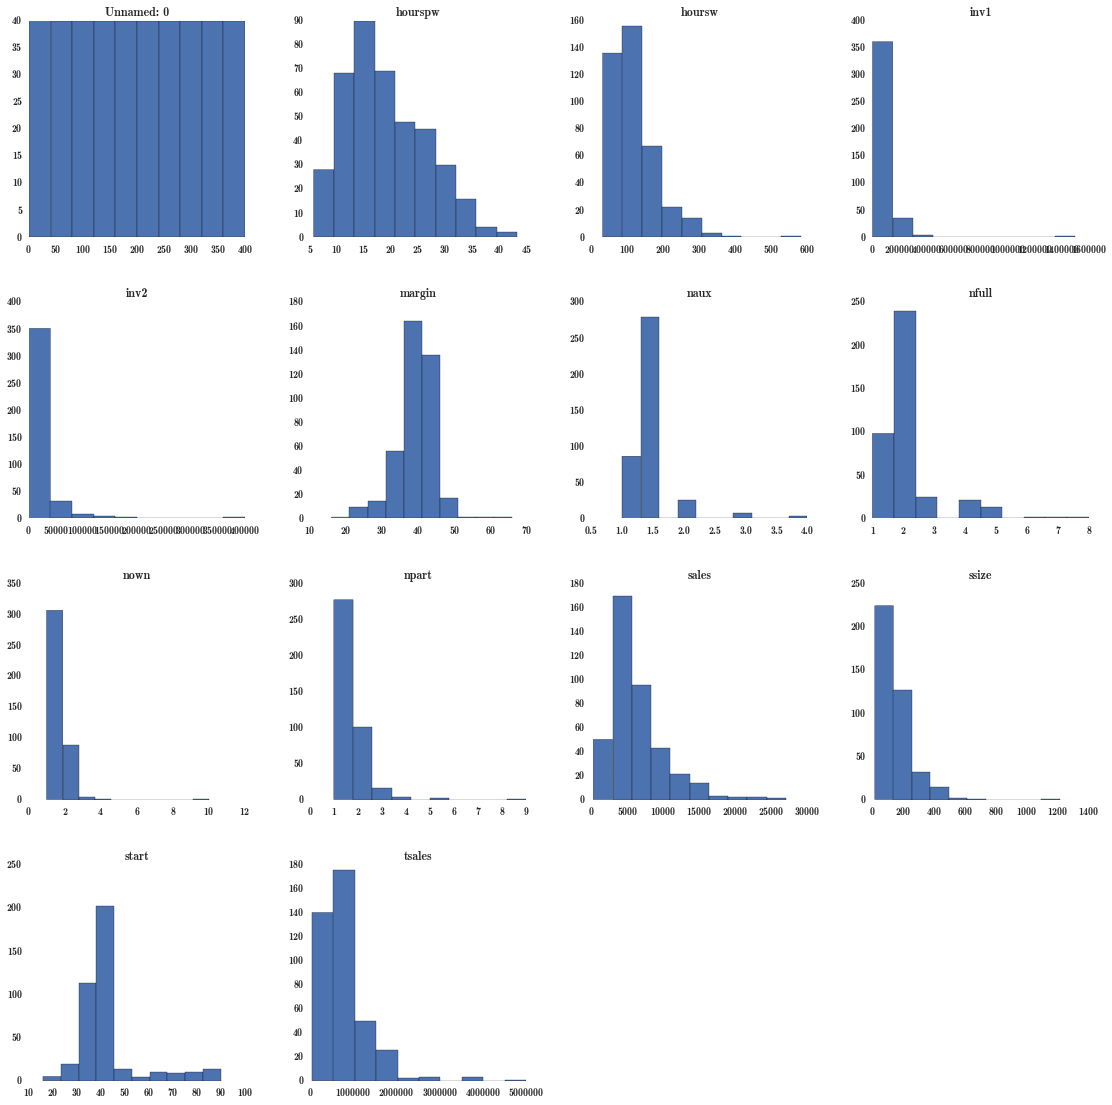

In [130]:
#study distribution of features
df.hist(figsize=(19,19))


- tsales: long tail  
- sales: long tail  
- margin: small standard deviation, "symmetric" (long tails on both sides)  
- hoursw: long tail distribution  
- inv1: 1 outlier  
- inv2: long tail  
- ssize: long tail or outlier?  
- nown: most stores have 1 or 2 owners, do we need to take nown >2 into account?  
- nfull: mainly <= 5  
- npart: mainly <= 3  
- naux : <= 2     

Possible transformations for hoursw, ssize and tsales



sales (sales per square meter) is a good indicator of the overall performance of a store, so we choose "sales per square meter" as the response (y) , and see how other features impact the response.

## study outliers for nown

In [131]:
#nown has only 2 very distincts outliers
#does removing them will have effects on the dataset summary stats?

#try removing outlier # 32
df_without_32 = df[(df['nown'] < 4) | (df['nown']> 4)]
df_without_32.describe()
# effect on tsales= decrease means and decrease std which is good?
#effect on inv1= decrease means, few impacts on std


#try removing outlier # 267
df_without_267 = df[(df['nown'] < 10)]
df_without_267.describe()
#effect on tsales = decrease mean (drastically) and std
#effect on sales = decrease mean (drastically) and std
#effects on hoursw= decrease mean and std
#effects on inv1 = decrease mean (drastically) and std
#effects on inv2 = decrease mean and std

#study rows 32 and 267
# sales in mean, margin close to mean, naux mean, hourspw close to mean, ssize and start close to mean
print df[32:33]
#margin close to mean, naux close to mean, start close to mean, the rest is pretty far from corresponding means
print df[267:268]


# Removing outliers might not be a good idea since the other columns have values close to the mean 
#==> too many impacts on dataset

    Unnamed: 0   tsales     sales  margin  nown  nfull  npart    naux  hoursw  \
32          33  1000000  7142.857      42     4      3      1  1.3333     190   

     hourspw    inv1    inv2  ssize  start  
32  20.35722  180000  100000    140     42  
     Unnamed: 0   tsales     sales  margin  nown  nfull   npart    naux  \
267         268  1926395  19263.95      40    10      4  2.2222  1.4091   

     hoursw   hourspw      inv1      inv2  ssize  start  
267     582  33.00948  292857.2  71570.55    100     40  


Removing the 2 outliers for nown might not be a good idea, since based on the other columns they are not outliers for.
They might be meaningful data for other features

## Interesting graph between margin and start: 

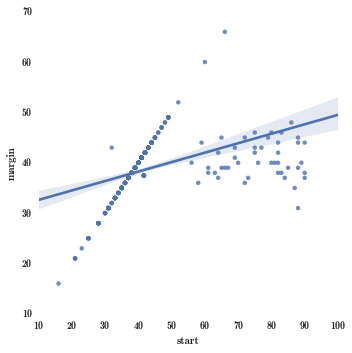

In [132]:
import seaborn as sns
sns.lmplot( 'start','margin',df)

In 1990, margins from stores that opened between 1910 and 1950 followed a linear model.

# Feature selection

In [133]:
# see if any feature got high f value and small p value

def f_regression_feature_selection(input, response):
    return fs.univariate_selection.f_regression(input, response)

# prepare X and y for feature selection
y = df['sales']
features = df.columns.tolist()


In [134]:
# remove 'Unnamed: 0' and 'sales' as they are not a feature; note that sales is the resopnse y
features.remove('Unnamed: 0')
features.remove('sales')
X = df[features]
X.head()

,tsales,margin,nown,nfull,npart,naux,hoursw,hourspw,inv1,inv2,ssize,start
0,750000,41,1,1.0000,1.0000,1.5357,76,16.75596,17166.67,27177.04,170,41
1,1926395,39,2,2.0000,3.0000,1.5357,192,22.49376,17166.67,27177.04,450,39
2,1250000,40,1,2.0000,2.2222,1.4091,114,17.19120,292857.20,71570.55,300,40
3,694227,40,1,1.0000,1.2833,1.3673,100,21.50260,22207.04,15000.00,260,40
4,750000,44,2,1.9556,1.2833,1.3673,104,15.74279,22207.04,10000.00,50,44


In [135]:
f_regression_feature_selection(X, y)

(array([  1.12776940e+02,   7.65263514e+00,   8.89997909e+00,
          2.37249489e+01,   1.00089825e+00,   8.13269391e-02,
          2.95741196e+01,   1.74759538e+01,   3.25664338e-04,
          7.71116370e-02,   3.75978139e+01,   1.71875013e+00]),
 array([  2.31572138e-23,   5.93315885e-03,   3.02737162e-03,
          1.60664484e-06,   3.17701112e-01,   7.75655516e-01,
          9.41201538e-08,   3.58046784e-05,   9.85611062e-01,
          7.81394662e-01,   2.09674561e-09,   1.90609913e-01]))

--> there are a number of f values > 10, which indicate potential features

In [136]:
# Now let's collect potential features that produce f values > 10
features_f = f_regression_feature_selection(X, y)[0] > 10
features_f

array([ True, False, False,  True, False, False,  True,  True, False,
       False,  True, False], dtype=bool)

In [137]:
X.columns[features_f]

Index([u'tsales', u'nfull', u'hoursw', u'hourspw', u'ssize'], dtype='object')

In [138]:
# sort features with f values - create feature-f_value tuples

fValues = zip(X.columns, f_regression_feature_selection(X,y)[0])
fValues = sorted(fValues, key = lambda x:x[1])
fValues

[('inv1', 0.00032566433824029496),
 ('inv2', 0.077111636993775323),
 ('naux', 0.081326939061948086),
 ('npart', 1.0008982512517497),
 ('start', 1.7187501289131084),
 ('margin', 7.6526351394707914),
 ('nown', 8.8999790883379202),
 ('hourspw', 17.475953756329584),
 ('nfull', 23.724948903830661),
 ('hoursw', 29.574119638175432),
 ('ssize', 37.597813931944273),
 ('tsales', 112.77694046800376)]

In [139]:
# Now we try to identify potential features that its p values <0.05
features_p = f_regression_feature_selection(X, y)[1] < 0.05
features_p

array([ True,  True,  True,  True, False, False,  True,  True, False,
       False,  True, False], dtype=bool)

In [140]:
X.columns[features_p]

Index([u'tsales', u'margin', u'nown', u'nfull', u'hoursw', u'hourspw', u'ssize'], dtype='object')

In [141]:
# create features-p_values tuples and sort it by p value
pValues = zip(X.columns, f_regression_feature_selection(X, y)[1])
pValues = sorted(pValues, key = lambda x: x[1])
pValues

[('tsales', 2.315721375046342e-23),
 ('ssize', 2.0967456144606454e-09),
 ('hoursw', 9.4120153750790732e-08),
 ('nfull', 1.6066448438113535e-06),
 ('hourspw', 3.5804678391755787e-05),
 ('nown', 0.0030273716176222672),
 ('margin', 0.0059331588498497661),
 ('start', 0.19060991255302306),
 ('npart', 0.31770111217204466),
 ('naux', 0.77565551595726612),
 ('inv2', 0.78139466229948273),
 ('inv1', 0.9856110622219747)]

In [142]:
# now let's look at R^2 for each feature
scores = []

for feat, p in pValues:
    est = Ridge()
    Xs = [[x] for x in X[feat]]
    est.fit(Xs, y)
    scores.append(est.score(Xs, y))

# create features-scores tuples
Scores = zip(X.columns, scores)
Scores = sorted(Scores, key = lambda x: x[1])
Scores

[('start', 8.1825143649627563e-07),
 ('ssize', 0.00019371030069181838),
 ('inv2', 0.00020424598817048167),
 ('inv1', 0.0025084484822831543),
 ('hourspw', 0.004299898686297321),
 ('hoursw', 0.018864995347607882),
 ('naux', 0.021871835607016332),
 ('npart', 0.042062491368231369),
 ('nfull', 0.05625659464815469),
 ('nown', 0.069167235059014232),
 ('margin', 0.086313137324001477),
 ('tsales', 0.22079489407777708)]

Findings so far:

- From p-values and f-values, it seems that 4 features should be taken away, namely 'inv1', 'inv2', 'naux', 'npart' because they produces both significantly low f-values (way smaller than 10) and high p-values (way higher than 0.05)

In [143]:
features2 = [x[0] for x in pValues]

features2

['tsales',
 'ssize',
 'hoursw',
 'nfull',
 'hourspw',
 'nown',
 'margin',
 'start',
 'npart',
 'naux',
 'inv2',
 'inv1']

In [144]:
# Now we build models with features adding one by one, and see the effect on R^2

feats = []
scores = []

for feat in features2:
    est = Ridge()
    
    # create Xs for modeling
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in X[feat]]
    else:
        Xs = X[feats]
    
    # build model and obtain scores
    est.fit(Xs, y)
    scores.append(est.score(Xs, y))
    
print feats
print scores

['tsales', 'ssize', 'hoursw', 'nfull', 'hourspw', 'nown', 'margin', 'start', 'npart', 'naux', 'inv2', 'inv1']
[0.22079489407777708, 0.63532702915095629, 0.64982394615389816, 0.65007965815607838, 0.65235413943469966, 0.65331240217730369, 0.65788284316165035, 0.65788788744719584, 0.65853479148010141, 0.65893753554939116, 0.65927272654051294, 0.65972284093823497]


To find the features with high R^2 impact, plot the cummulative scores, from strong to weak features according to pValues

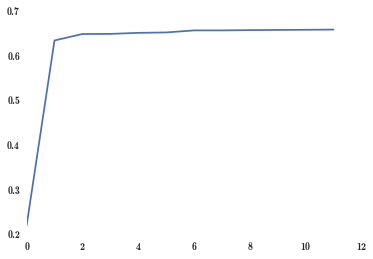

In [145]:
plt.plot(range(len(scores)), scores)

--> quite some features does not give much impact to R^2.

Now proceed to see if the features are highly correlated or not:

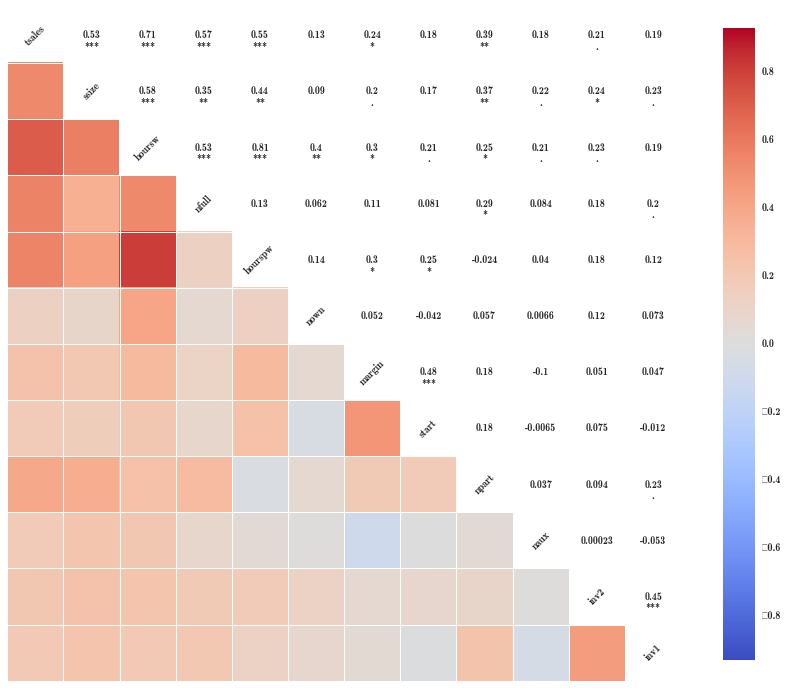

In [146]:
correlation = X[features2]
f, ax = plt.subplots(figsize=(12, 12))
sns.corrplot(correlation, ax=ax)
f.tight_layout()

Some correlation but not all very highly correlated except hoursw and hourspw

In [147]:
features2

['tsales',
 'ssize',
 'hoursw',
 'nfull',
 'hourspw',
 'nown',
 'margin',
 'start',
 'npart',
 'naux',
 'inv2',
 'inv1']

In [148]:
# re-build model to check R^2 with new set of features, and check with correlation plot
feats = []
scores = []

for feat in features2:
    est = Ridge()
    
    # create Xs for modeling
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in X[feat]]
        
    else:
        Xs = X[feats]
    
    # build model and obtain scores
    est.fit(Xs, y)
    scores.append(est.score(Xs, y))
    
print feats
print scores

['tsales', 'ssize', 'hoursw', 'nfull', 'hourspw', 'nown', 'margin', 'start', 'npart', 'naux', 'inv2', 'inv1']
[0.22079489407777708, 0.63532702915095629, 0.64982394615389816, 0.65007965815607838, 0.65235413943469966, 0.65331240217730369, 0.65788284316165035, 0.65788788744719584, 0.65853479148010141, 0.65893753554939116, 0.65927272654051294, 0.65972284093823497]


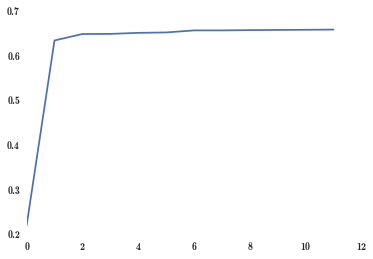

In [149]:
plt.plot(range(len(scores)), scores)

hoursw and hourswp are highly correlated

In [150]:
# build model by the handpicked key features, and see the R^2
est = Ridge()
Xs = X[['tsales', 'ssize', 'hoursw', 'nfull','nown']]
est.fit(Xs, y)
est.score(Xs, y)

0.6529457109755874

# supplement: feature selection by RFE

In [151]:
# create RFE object to rank features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_

scores = zip(X.columns, ranking)
scores = sorted(scores, key = lambda x:x[1])
scores

[('nfull', 1),
 ('nown', 2),
 ('naux', 3),
 ('hourspw', 4),
 ('npart', 5),
 ('margin', 6),
 ('ssize', 7),
 ('start', 8),
 ('hoursw', 9),
 ('tsales', 10),
 ('inv2', 11),
 ('inv1', 12)]

In [152]:
# build model with cummulative features, one by one, in the order or RFE rank

feats = []
score_rfe = []

for feat, r in scores:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in X[feat]]
        
        #debug
        #print Xs
    else:
        Xs = X[feats]
        
        #debug
        #print Xs.head()
    
    est.fit(Xs, y)
    score_rfe.append(est.score(Xs, y))

print feats
print score_rfe

['nfull', 'nown', 'naux', 'hourspw', 'npart', 'margin', 'ssize', 'start', 'hoursw', 'tsales', 'inv2', 'inv1']
[0.05625659464815469, 0.074057028843585448, 0.075252393249334193, 0.10148470530156961, 0.101653170769474, 0.10554216543291117, 0.42649308793805429, 0.42709211567866112, 0.4271522166214976, 0.65893753554939105, 0.65927272654051294, 0.65972284093823497]


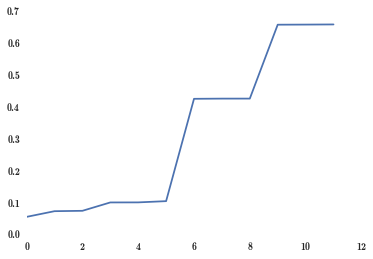

In [153]:
plt.plot(range(len(score_rfe)), score_rfe)

--> tsales and ssize has shown significant impact to R^2

Let's sum up the insight from univartie and multivariate analysis of f-value, p-value, R^2, RFE:

<img src="files/feature_selection.png" style="width: 80%;">


For now, key features in the hypothesis: tsales, ssize, nfull, nown, hoursw

Add polynomial features using dmatrix(C(feat, Poly), X) [Failed...]

In [154]:
features3 = ['tsales', 'ssize', 'hoursw', 'nfull','nown']

In [155]:
poly_features = []

In [156]:
[poly_features.append(dmatrix('C(' + str(feat) + ', Poly)', X)) for feat in features3];

In [157]:
poly_features_123 = [poly[:,1:4] for poly in poly_features]
poly_features_123

[array([[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]]), array([[ 0.01496543, -0.11228594, -0.03390039],
        [ 0.15713704,  0.15439317,  0.10928275],
        [ 0.10849938,  0.01357806, -0.09416521],
        ..., 
        [-0.06360309, -0.0706364 ,  0.11466666],
        [ 0.13468889,  0.08299396, -0.01309477],
        [-0.11224074,  0.02257924,  0.08619581]]), array([[-0.086392  ,  0.01655568,  0.06744886],
        [ 0.08120848,  0.00430728, -0.0776843 ],
        [-0.0259176 , -0.07920071,  0.05587009],
        ..., 
        [-0.06393008, -0.03104892,  0.09361138],
        [ 0.05356304, -0.04822194, -0.09163898],
        [-0.08984768,  0.02514219,  0.05906929]]), array([[-0.45993311,  0.50182816, -0.45993311],
        [-0.2090605 , -0.15511052,  0.34843417],
        [-0.2090605 , -0.15511052,  0.34843417],
        ..., 
        [-0.45993311,  0.50182816, -0.

In [158]:
dfs = [pd.DataFrame(poly_features_123[x]) for x in range(5)]

In [159]:
dfs

[      0   1   2
 0   NaN NaN NaN
 1   NaN NaN NaN
 2   NaN NaN NaN
 3   NaN NaN NaN
 4   NaN NaN NaN
 5   NaN NaN NaN
 6   NaN NaN NaN
 7   NaN NaN NaN
 8   NaN NaN NaN
 9   NaN NaN NaN
 10  NaN NaN NaN
 11  NaN NaN NaN
 12  NaN NaN NaN
 13  NaN NaN NaN
 14  NaN NaN NaN
 15  NaN NaN NaN
 16  NaN NaN NaN
 17  NaN NaN NaN
 18  NaN NaN NaN
 19  NaN NaN NaN
 20  NaN NaN NaN
 21  NaN NaN NaN
 22  NaN NaN NaN
 23  NaN NaN NaN
 24  NaN NaN NaN
 25  NaN NaN NaN
 26  NaN NaN NaN
 27  NaN NaN NaN
 28  NaN NaN NaN
 29  NaN NaN NaN
 ..   ..  ..  ..
 370 NaN NaN NaN
 371 NaN NaN NaN
 372 NaN NaN NaN
 373 NaN NaN NaN
 374 NaN NaN NaN
 375 NaN NaN NaN
 376 NaN NaN NaN
 377 NaN NaN NaN
 378 NaN NaN NaN
 379 NaN NaN NaN
 380 NaN NaN NaN
 381 NaN NaN NaN
 382 NaN NaN NaN
 383 NaN NaN NaN
 384 NaN NaN NaN
 385 NaN NaN NaN
 386 NaN NaN NaN
 387 NaN NaN NaN
 388 NaN NaN NaN
 389 NaN NaN NaN
 390 NaN NaN NaN
 391 NaN NaN NaN
 392 NaN NaN NaN
 393 NaN NaN NaN
 394 NaN NaN NaN
 395 NaN NaN NaN
 396 NaN NaN N

##Polynomial Features - using SciKit Learn

In [160]:
Xs = X[features3]
Xs.head()


,tsales,ssize,hoursw,nfull,nown
0,750000,170,76,1.0000,1
1,1926395,450,192,2.0000,2
2,1250000,300,114,2.0000,1
3,694227,260,100,1.0000,1
4,750000,50,104,1.9556,2


In [161]:
poly = PolynomialFeatures(3)
poly_Xs = poly.fit_transform(Xs)

In [162]:
poly_Xs

array([[  1.00000000e+00,   7.50000000e+05,   1.70000000e+02, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.92639500e+06,   4.50000000e+02, ...,
          8.00000000e+00,   8.00000000e+00,   8.00000000e+00],
       [  1.00000000e+00,   1.25000000e+06,   3.00000000e+02, ...,
          4.00000000e+00,   2.00000000e+00,   1.00000000e+00],
       ..., 
       [  1.00000000e+00,   5.17381000e+05,   1.00000000e+02, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.25232000e+06,   3.75000000e+02, ...,
          4.00000000e+00,   2.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   6.00000000e+05,   7.00000000e+01, ...,
          3.82437136e+00,   1.95560000e+00,   1.00000000e+00]])

In [163]:
est = Ridge()
print "R^2 = " + str(est.fit(poly_Xs, y).score(poly_Xs, y)) + "with no. of features = " + str(len(poly_Xs[0]))

R^2 = 0.962542120242with no. of features = 56


##Polynomial features - creating manually

First we create X^2 and X^3 for all the 5 features

In [164]:
df[features3].head()

,tsales,ssize,hoursw,nfull,nown
0,750000,170,76,1.0000,1
1,1926395,450,192,2.0000,2
2,1250000,300,114,2.0000,1
3,694227,260,100,1.0000,1
4,750000,50,104,1.9556,2


In [165]:
dfp = df[features3]
dfp.head()

,tsales,ssize,hoursw,nfull,nown
0,750000,170,76,1.0000,1
1,1926395,450,192,2.0000,2
2,1250000,300,114,2.0000,1
3,694227,260,100,1.0000,1
4,750000,50,104,1.9556,2


In [166]:
dfp['tsales2'] = dfp['tsales']**2
dfp['tsales3'] = dfp['tsales']**3
dfp['ssize2'] = dfp['ssize']**2
dfp['ssize3'] = dfp['ssize']**3
dfp['hoursw2'] = dfp['hoursw']**2
dfp['hoursw3'] = dfp['hoursw']**3
dfp['nfull2'] = dfp['nfull']**2
dfp['nfull3'] = dfp['nfull']**3
dfp['nown2'] = dfp['nown']**2
dfp['nown3'] = dfp['nown']**3

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the cav

In [167]:
dfp.head()

,tsales,ssize,hoursw,nfull,nown,tsales2,tsales3,ssize2,ssize3,hoursw2,hoursw3,nfull2,nfull3,nown2,nown3
0,750000,170,76,1.0000,1,562500000000,421875000000000000,28900,4913000,5776,438976,1.000000,1.000000,1,1
1,1926395,450,192,2.0000,2,3710997696025,7148847406634080256,202500,91125000,36864,7077888,4.000000,8.000000,4,8
2,1250000,300,114,2.0000,1,1562500000000,1953125000000000000,90000,27000000,12996,1481544,4.000000,8.000000,1,1
3,694227,260,100,1.0000,1,481951127529,334583485411075072,67600,17576000,10000,1000000,1.000000,1.000000,1,1
4,750000,50,104,1.9556,2,562500000000,421875000000000000,2500,125000,10816,1124864,3.824371,7.478941,4,8


In [168]:
# perform RFE and see which feature produce the most impact
# create RFE object to rank features
Xp = dfp

est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)
rfe.fit(Xp, y)
ranking = rfe.ranking_

ranks = zip(Xp.columns, ranking)
ranks = sorted(ranks, key = lambda x:x[1])
ranks

[('nfull', 1),
 ('nown2', 2),
 ('nown', 3),
 ('nown3', 4),
 ('hoursw', 5),
 ('ssize', 6),
 ('nfull3', 7),
 ('nfull2', 8),
 ('hoursw2', 9),
 ('ssize2', 10),
 ('tsales', 11),
 ('hoursw3', 12),
 ('ssize3', 13),
 ('tsales2', 14),
 ('tsales3', 15)]

--> nown2 ranked higher than nown

In [169]:
# build model with cummulative features, one by one, in the order or RFE rank

feats = []
score_rfe = []

for feat, r in ranks:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in Xp[feat]]
        
        #debug
        #print Xs
    else:
        Xs = Xp[feats]
        
        #debug
        #print Xs.head()
    
    est.fit(Xs, y)
    score_rfe.append(est.score(Xs, y))

print feats
print score_rfe

['nfull', 'nown2', 'nown', 'nown3', 'hoursw', 'ssize', 'nfull3', 'nfull2', 'hoursw2', 'ssize2', 'tsales', 'hoursw3', 'ssize3', 'tsales2', 'tsales3']
[0.05625659464815469, 0.079389317937233472, 0.07939375783874647, 0.086079045992565995, 0.098169223876397371, 0.39688732084216083, 0.41121616019012897, 0.41121654809437369, 0.42079818043145845, 0.48373998712644894, 0.80067904638649612, 0.80281199980660412, 0.84085079484256653, 0.86523210400266481, 0.8684618311932023]


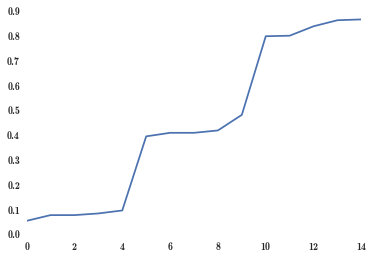

In [170]:
plt.plot(range(len(score_rfe)), score_rfe)

--> nfull3 is the polynomial features that it's R^2 performs well here

In [171]:
# f-value analysis to find the best perform features
fValues = zip(Xp.columns, f_regression_feature_selection(Xp, y)[0])
fValues = sorted(fValues, key = lambda x: x[1], reverse=True)
fValues

[('tsales', 112.77694046800376),
 ('tsales2', 72.743793628486017),
 ('ssize', 37.597813931944273),
 ('hoursw', 29.574119638175432),
 ('hoursw2', 26.177109319802135),
 ('nfull2', 24.173608480084368),
 ('nfull', 23.724948903830661),
 ('hoursw3', 21.09594814630384),
 ('nfull3', 20.63876665601363),
 ('ssize2', 15.767265107578529),
 ('nown3', 12.411953838869076),
 ('nown2', 12.322144732808866),
 ('nown', 8.8999790883379202),
 ('ssize3', 5.4346486961956382),
 ('tsales3', 0.060340433157539147)]

In [172]:
# build model with features adding one by one, in f-value's descending order
feats = []
Scores = []

for feat, r in fValues:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in Xp[feat]]
        
        #debug
        #print Xs
    else:
        Xs = Xp[feats]
        
        #debug
        #print Xs.head()
    
    est.fit(Xs, y)
    Scores.append(est.score(Xs, y))

print feats
print Scores

['tsales', 'tsales2', 'ssize', 'hoursw', 'hoursw2', 'nfull2', 'nfull', 'hoursw3', 'nfull3', 'ssize2', 'nown3', 'nown2', 'nown', 'ssize3', 'tsales3']
[0.22079489407777708, 0.22533413677419623, 0.68677943757516013, 0.68870406070259427, 0.69640550560872838, 0.69929343655757537, 0.70049449644433825, 0.70165458614782727, 0.70197180562440187, 0.82452299291121112, 0.82477162919526958, 0.82499511875717269, 0.82616191389488536, 0.86523210400266504, 0.86846183119320242]


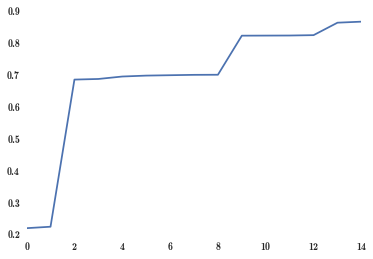

In [173]:
plt.plot(range(len(Scores)), Scores)

--> tsales2 shows high f-value and high impact on R^2

In [174]:
# create features-p_values tuples and sort it by p value
pValues = zip(Xp.columns, f_regression_feature_selection(Xp, y)[1])
pValues = sorted(pValues, key = lambda x: x[1])
pValues

[('tsales', 2.315721375046342e-23),
 ('tsales2', 3.1193541109463531e-16),
 ('ssize', 2.0967456144606454e-09),
 ('hoursw', 9.4120153750790732e-08),
 ('hoursw2', 4.8550333162700657e-07),
 ('nfull2', 1.28964728629765e-06),
 ('nfull', 1.6066448438113535e-06),
 ('hoursw3', 5.8699025918959153e-06),
 ('nfull3', 7.3639166692727905e-06),
 ('ssize2', 8.5004063423091609e-05),
 ('nown3', 0.00047609472371129406),
 ('nown2', 0.00049882624657927876),
 ('nown', 0.0030273716176222672),
 ('ssize3', 0.020239604376131551),
 ('tsales3', 0.80608529845631205)]

--> tsales2, hoursw2, nfull2 performed will in p-values

In [175]:
# build model with features adding one by one, in f-value's descending order
feats = []
Scores = []

for feat, p in fValues:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        Xs = [[x] for x in Xp[feat]]
        
        #debug
        #print Xs
    else:
        Xs = Xp[feats]
        
        #debug
        #print Xs.head()
    
    est.fit(Xs, y)
    Scores.append(est.score(Xs, y))

print feats
print Scores

['tsales', 'tsales2', 'ssize', 'hoursw', 'hoursw2', 'nfull2', 'nfull', 'hoursw3', 'nfull3', 'ssize2', 'nown3', 'nown2', 'nown', 'ssize3', 'tsales3']
[0.22079489407777708, 0.22533413677419623, 0.68677943757516013, 0.68870406070259427, 0.69640550560872838, 0.69929343655757537, 0.70049449644433825, 0.70165458614782727, 0.70197180562440187, 0.82452299291121112, 0.82477162919526958, 0.82499511875717269, 0.82616191389488536, 0.86523210400266504, 0.86846183119320242]


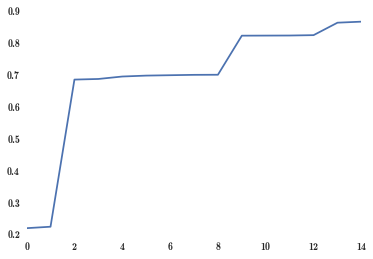

In [176]:
plt.plot(range(len(Scores)), Scores)

--> tsales2 got good p-value and high R^2 impact

Therefore, pick these features as well: nfull3, tsales2, ssize2

In [108]:
features4 = features3
features4.append('ssize2')
features4.append('nfull3')
features4.append('tsales2')
features4

['tsales', 'ssize', 'hoursw', 'nfull', 'nown', 'ssize2', 'nfull3', 'tsales2']

In [179]:
# build model by the the new set of features, and see the R^2
est = Ridge()
Xs = dfp[features4]
est.fit(Xs, y)
est.score(Xs, y)

0.81787615654764434

In [183]:
print features4
est.coef_

['tsales', 'ssize', 'hoursw', 'nfull', 'nown', 'ssize2', 'nfull3', 'tsales2']


array([  1.07095660e-02,  -5.04157348e+01,  -3.02225080e+00,
         1.27918524e+02,   3.86391515e+02,   3.08023536e-02,
         3.91039726e-01,  -1.33287370e-09])

In [184]:
est.intercept_

4908.463300442234

# Feature selection attempt #2

Let's try to see if we can get a better R^2 with y= tsales, since sales is also calculated from tsales

In [66]:
df = pd.read_csv("Clothing.csv")
#let's use tsales as dependent variable
y = df['tsales']
# we are not interested in margin and sales (since they are calculated from tsales)
selection = df._get_numeric_data().columns - [ 'tsales', 'margin','sales', 'Unnamed: 0']

X = df[selection]
#only get features with f-values < 10
selection = f_regression_feature_selection(X,y)[0]<10
print X.columns[selection]
select = pd.Index(X.columns).difference(pd.Index(X.columns[selection])) 
Xs = X[select]
Xs.head()

# we can see that only nown did not qualify

Index([u'nown'], dtype='object')


,hourspw,hoursw,inv1,inv2,naux,nfull,npart,ssize,start
0,16.75596,76,17166.67,27177.04,1.5357,1.0000,1.0000,170,41
1,22.49376,192,17166.67,27177.04,1.5357,2.0000,3.0000,450,39
2,17.19120,114,292857.20,71570.55,1.4091,2.0000,2.2222,300,40
3,21.50260,100,22207.04,15000.00,1.3673,1.0000,1.2833,260,40
4,15.74279,104,22207.04,10000.00,1.3673,1.9556,1.2833,50,44


In [67]:
#P-values
#how many features dont have p- values <=0.05
print sum(f_regression_feature_selection(Xs,y)[1]> 0.05)

#sort features based on pvalues
ps=f_regression_feature_selection(Xs,y)[1]
#matrix of columns and their corresponding pvalues
p_score = zip(Xs.columns,ps)
#sort them with pvalues asc
ranked_p=sorted(p_score,key=lambda x:x[1])
ranked_p

0


[('hoursw', 2.1472109468434076e-62),
 ('nfull', 4.1103438885674863e-35),
 ('hourspw', 2.5353318943196061e-33),
 ('ssize', 8.1632258827702277e-31),
 ('npart', 4.7559984156082264e-16),
 ('inv2', 3.5521192738224436e-05),
 ('inv1', 0.00012605380603932808),
 ('naux', 0.00027392856900721499),
 ('start', 0.00027763493024215389)]

[('hoursw', 2.1472109468434076e-62), ('nfull', 4.1103438885674863e-35), ('hourspw', 2.5353318943196061e-33), ('ssize', 8.1632258827702277e-31), ('npart', 4.7559984156082264e-16), ('inv2', 3.5521192738224436e-05), ('inv1', 0.00012605380603932808), ('naux', 0.00027392856900721499), ('start', 0.00027763493024215389)]
[0.50295939545656021, 0.31923276039446524, 0.3050645863227005, 0.28472583114325178, 0.152755557266127, 0.042098871569849372, 0.036305248863147677, 0.032753021081531775, 0.03269995078485044]


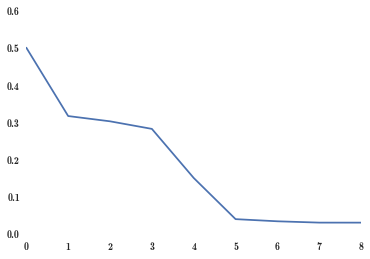

In [68]:
# get individual R^2

from sklearn.linear_model import Ridge
scores = []
for feat, score in ranked_p:
    est=Ridge()
    X = [[x] for x in Xs[feat]]
    est.fit(X,y)
    scores.append(est.score(X,y))

print ranked_p
#Scores = zip(X.columns, scores)
#Scores = sorted(Scores, key = lambda x: x[1])
print scores
plt.plot(range(len(scores)),scores)


['hoursw', 'nfull', 'hourspw', 'ssize', 'npart', 'inv2', 'inv1', 'naux', 'start']
[0.50295939545656021, 0.55230958095139915, 0.56834463187452955, 0.58888442336722302, 0.63366940183958254, 0.63367645535584538, 0.63452284722959473, 0.64538621902348448, 0.64654278811907573]


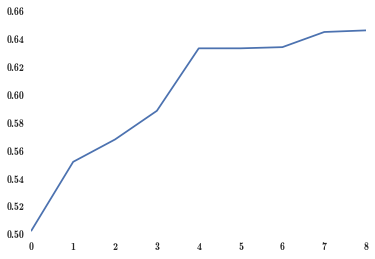

In [69]:
#Now R^2 with all features combined
feats = []
scores = []

for feat,score  in ranked_p:
    est = Ridge()
    
    # create Xs for modeling
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    
    # build model and obtain scores
    est.fit(X, y)
    scores.append(est.score(X, y))
    
print feats
print scores
plt.plot(range(len(scores)), scores)

We can see that even by using tsales we are not able to get a better R^2

However by using transformations on some features we have been able to get better R^2 but with highly correlated Xs:

 - by using nfull$^3$ + nfull$^2$ + hoursw$^2$ + hoursw 

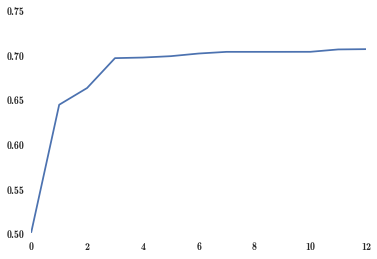

In [70]:
feats=['hoursw', 'cnfull', 'sqfull', 'hourswsq', 'nfull', 'hourspw', 'ssize', 'hourswc', 'npart', 'inv2', 'inv1', 'naux', 'start']
scores=[0.50295939545656021, 0.64566863463470447, 0.66440701050743023, 0.69787726718611509, 0.69855219639142585, 0.70007763600758766, 0.70305045459029136, 0.70491888879630515, 0.70491925119271714, 0.70492605831685418, 0.70496191691584487, 0.70762013402692081, 0.70795483380379332]
plt.plot(range(len(scores)), scores)

['hoursw', 'cnfull', 'sqfull', 'hourswsq', 'nfull', 'hourspw', 'ssize', 'hourswc', 'npart', 'inv2', 'inv1', 'naux', 'start']  
[0.50295939545656021, 0.64566863463470447, 0.66440701050743023, 0.69787726718611509, 0.69855219639142585, 0.70007763600758766, 0.70305045459029136, 0.70491888879630515, 0.70491925119271714, 0.70492605831685418, 0.70496191691584487, 0.70762013402692081, 0.70795483380379332]

# Conclusion

No big differences in R^2 when using tsales as Y (without transformation or 2nd/3rd degree variables), so sales is a good choice of Y in the end . 

Surprisingly "inv" variable have very few effect and after taking a look at the dataset, we found a lot of similar values for many rows.

Which features are the most significant in the end:

  - if y = sales:  tsales and  ssize, 
  - if y = tsales:  hoursw and nfull 

- 

Plotting the residuals may help us know if we missed anything in our model


So far the best model we got is with Y = sales and with the following features:
['tsales', 'ssize', 'hoursw', 'nfull', 'nown', 'ssize2']

with coefficients = 6.00109262e-03,  -4.71598783e+01,   9.22177633e+00, -3.57987653e+02,   2.45948928e+02,   2.80916006e-02])

and intercept = 6768.2224052065039